# Mauna Loa CO2

In this Notebook (as a lot of other ones) we'll consider modelling the Mauna Loa CO2 dataset using structural timeseries in numpyro. As always, we begin importing the data

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

datas = fetch_openml(data_id=41187, as_frame=True).frame
datas.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


Let's construct a proper date time value and set as index

In [2]:
datas.index = datas.apply(lambda u: pd.Timestamp(year=u["year"], month=u["month"], day=u["day"]), axis=1)

datas.head()

,year,month,day,weight,flag,station,co2
1958-03-29,1958,3,29,4,0,MLO,316.1
1958-04-05,1958,4,5,6,0,MLO,317.3
1958-04-12,1958,4,12,4,0,MLO,317.6
1958-04-19,1958,4,19,6,0,MLO,317.5
1958-04-26,1958,4,26,2,0,MLO,316.4


Let's only select the CO2 column and resample to monthly

Text(0.5, 1.0, 'CO2 at Mauna Loa')

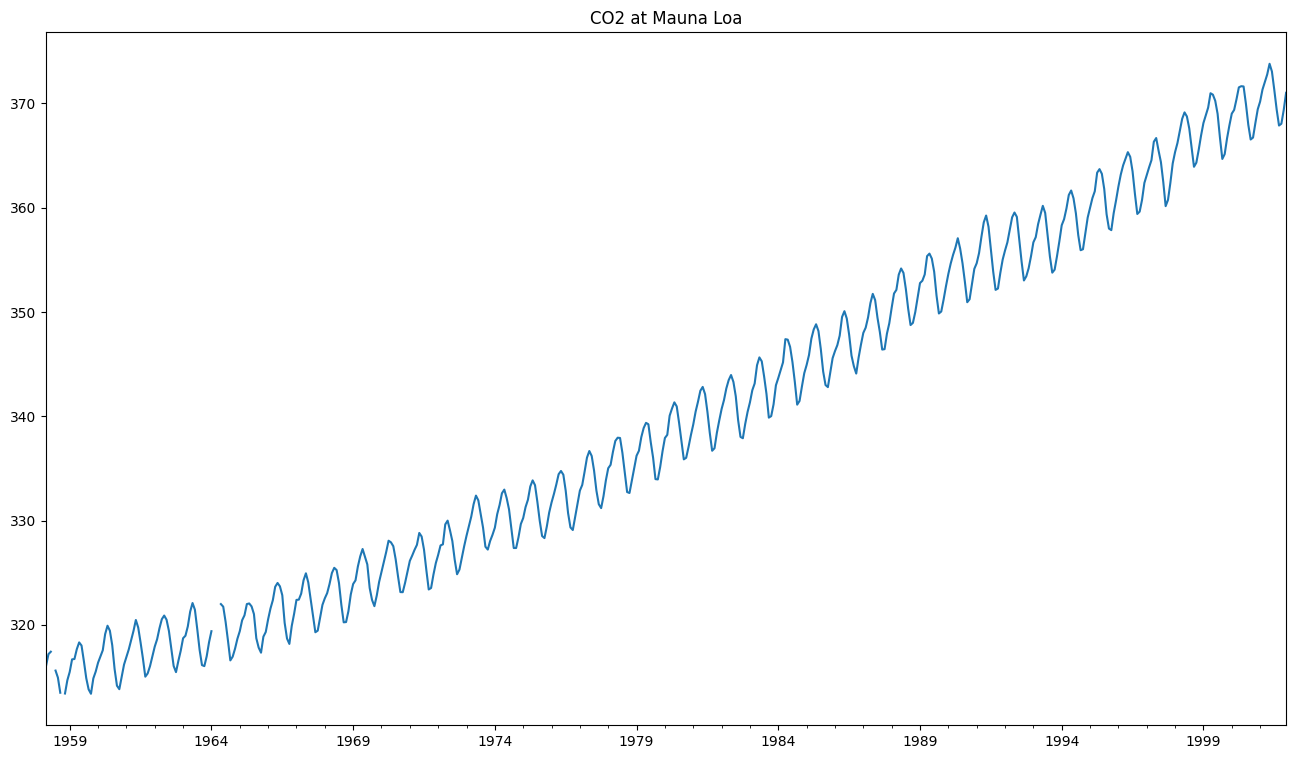

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

co2 = datas["co2"].resample("ME").mean()

fig, ax = plt.subplots()
co2.plot(ax=ax)

ax.set_title("CO2 at Mauna Loa")

We clearly see that there is both a trend and seasonality component in the data. The model seems to be additive as it doesn't grow/shrink with time. As such, let's set up our model

In [16]:
from numpyro.contrib.control_flow import scan
from numpyro.distributions import HalfNormal, Normal, HalfCauchy, ZeroSumNormal
import numpyro
from numpyro_sts import periodic, RandomWalk
import numpy as np
import jax.numpy as jnp


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")


def model(n: int, y: np.ndarray = None, mask: bool = True, num_seasons: int = 12):
    # level component
    with numpyro.handlers.scope(prefix="level"):
        std = numpyro.sample("std", HalfNormal(scale=100.0))
        drift = numpyro.sample("drift", HalfNormal())

        x_0_loc = numpyro.sample("x_0_loc", Normal(scale=1000.0))
        x_0 = x_0_loc + numpyro.sample("x_0", Normal())

        local_linear = RandomWalk(n, std, x_0, drift=drift)
        level = numpyro.sample("x", local_linear)

    # seasonality
    with numpyro.handlers.scope(prefix="seasonality"):
        x_0 = numpyro.sample("x_0", ZeroSumNormal(scale=10.0, event_shape=(num_seasons,)))[:-1]

        seasonality_model = periodic.TimeSeasonal(n, num_seasons, std, x_0)
        seasonality = numpyro.deterministic("x", seasonality_model.constant_seasonal())

    # observable
    std = numpyro.sample("std", HalfCauchy())
    loc = level[..., 0] + seasonality[..., 0]

    with numpyro.handlers.mask(mask=mask):
        y_ = numpyro.sample("y", Normal(loc, std), obs=y)

    return

Since we have a fully probabilistic model, let's sample from the model and see it's outputs

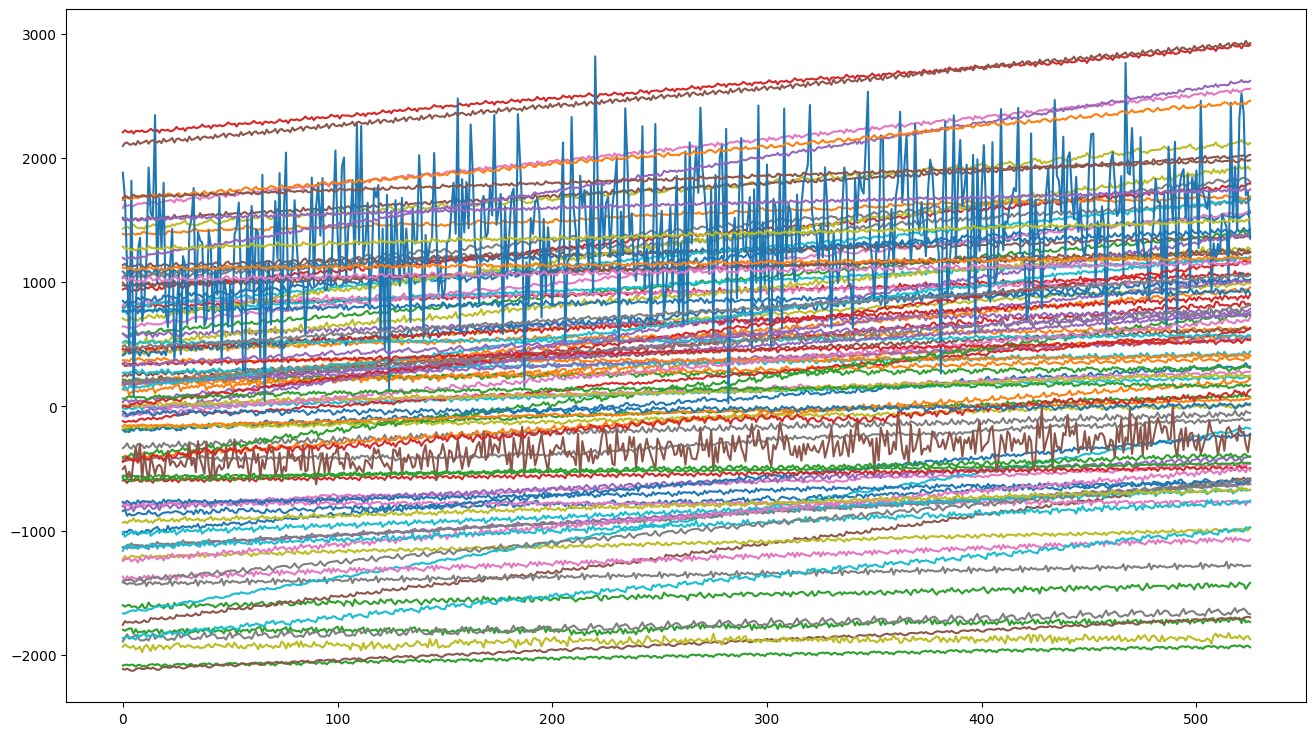

In [15]:
from numpyro.infer import Predictive
import jax.random as jrnd

predictive = Predictive(model, num_samples=100)
key = jrnd.PRNGKey(0)

samples = predictive(key, n=co2.shape[0])

fig, ax = plt.subplots()
ax.plot(samples["y"].swapaxes(0, -1))

Alright, let's perform some inference

In [6]:
from numpyro.infer import NUTS, MCMC

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5_000, num_samples=1_000, num_chains=4, chain_method="sequential")
mcmc.run(key, n=co2.shape[0], y=co2.values, mask=np.isfinite(co2.values))

sample: 100%|██████████| 6000/6000 [00:20<00:00, 288.54it/s, 15 steps of size 2.14e-01. acc. prob=0.87] 


In [9]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
        level/drift      0.11      0.01      0.11      0.09      0.13   4628.19      1.00
          level/std      0.23      0.02      0.23      0.21      0.26    378.26      1.01
       level/x[0,0]    314.64      0.14    314.64    314.42    314.87   2089.63      1.00
       level/x[1,0]    314.67      0.12    314.67    314.46    314.86   2366.06      1.00
       level/x[2,0]    314.64      0.13    314.64    314.43    314.86   1871.67      1.00
       level/x[3,0]    314.90      0.20    314.90    314.58    315.21   1937.91      1.00
       level/x[4,0]    315.15      0.13    315.15    314.94    315.38   1152.28      1.00
       level/x[5,0]    316.00      0.13    316.00    315.79    316.22   2046.98      1.00
       level/x[6,0]    316.28      0.14    316.28    316.05    316.50   1291.92      1.00
       level/x[7,0]    315.94      0.19    315.94    315.63    316.24   3247.02      1.00
       le